# AP-1 Peak Calling

In [ ]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

In [13]:
workingDirectory = '/home/jtao/analysis/ap1_analysis/'
os.chdir(workingDirectory)
peakDirectory = '/home/jtao/analysis/ap1_analysis/peak_files/'
scratchDirectory = '/home/jtao/analysis/ap1_analysis/scratch'
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories/'

## C57Bl6 ChIPs

### Preprocessing

In [ ]:
# file directories

os.chdir(workingDirectory)

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(tagDirPath)):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in sorted(os.listdir(tagDirPath)):
    logFile = [x for x in os.listdir(tagDirPath + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(tagDirPath + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

### Mapping Quality Control

In [ ]:
# plot distribution of uniquely mapped reads
sns.distplot(mapping_summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(mapping_summary_frame['tagsPerPosition'].values, bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()


# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(mapping_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()


plt.scatter(x = mapping_summary_frame['totalReads'].astype(float).values, y=mapping_summary_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [ ]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))



### Peak Calling

In [ ]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    if "veh" in treatment.lower():
        inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
    elif "kla" in treatment.lower():
        inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
    scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 200 -minDist 200 > ' + 
                     peakDirectory +'/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                 ' -i ' + inputDir
                 + ' -style factor -size 200 -minDist 200 > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



In [ ]:
%%bash
rm ./peak_files/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr.sh

### Run IDR

In [ ]:
idrDirectory = '/home/jtao/analysis/ap1_analysis/ap1_idr/'
scriptFile = open(scratchDirectory + '/run_idr.sh', 'w')

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./ap1_idr/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
counter = 0
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.05"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

In [ ]:
%%bash
# rm ./ap1_idr/*
chmod a+x ./scratch/*
bash ./scratch/run_idr.sh

In [ ]:
# remove pseudo biological replicates by Sven and Casey
!rm ./ap1_idr/*12-11-08*12-11-08*

In [ ]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ap1_analysis/ap1_idr/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar')
plt.xticks(rotation=90)
# plt.ylim([0,30000])
    

In [ ]:
outFile = open('./best_samples.tsv','w')
! if [ ! -d idrPeaks ]; then mkdir idrPeaks; fi
!rm ./idrPeaks/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()



In [40]:
# Create bed Files
bedDir = './bed_files'
peakDir = './idrPeaks/'

if not os.path.isdir(bedDir):
    os.mkdir(bedDir)
    
combined_bed_file = open(bedDir + '/combined.bed', 'w')
for pf in sorted(os.listdir(peakDir)):
# for pf in ['c57bl6_atf3_veh_peaks.tsv', 'c57bl6_cjun_veh_peaks.tsv', 'c57bl6_jund_veh_peaks.tsv']:
    if ('peaks.tsv') in pf:
        print(pf)
        with open(peakDir + '/' + pf) as f:
            data = f.readlines()
        name = pf.replace('_peaks.tsv','')
        current_bed_file = open(bedDir + '/' + name + '.bed', 'w')
        for line in data[1:]:
            tokens = line.strip().split('\t')
            chrom = tokens[1]
            chromStart = tokens[2]
            chromEnd = tokens[3]
            score = tokens[6] # peakScore
            strand = tokens[4]
            bedLine = '\t'.join([chrom, 
                                  chromStart,
                                  chromEnd,
                                  name,
                                  score,
                                  strand,
                                  '\n'])
            combined_bed_file.write(bedLine)
            current_bed_file.write(bedLine)
        current_bed_file.close()
combined_bed_file.close()

c57bl6_atf3_kla_peaks.tsv
c57bl6_atf3_veh_peaks.tsv
c57bl6_cebpa_kla_peaks.tsv
c57bl6_cebpa_veh_peaks.tsv
c57bl6_cjun_kla_peaks.tsv
c57bl6_cjun_veh_peaks.tsv
c57bl6_fos_kla_peaks.tsv
c57bl6_fos_veh_peaks.tsv
c57bl6_fra2_kla_peaks.tsv
c57bl6_fra2_veh_peaks.tsv
c57bl6_junb_kla_peaks.tsv
c57bl6_junb_veh_peaks.tsv
c57bl6_jund_kla_peaks.tsv
c57bl6_jund_veh_peaks.tsv
c57bl6_p65_kla_peaks.tsv
c57bl6_p65_veh_peaks.tsv
c57bl6_pu1_kla_peaks.tsv
c57bl6_pu1_veh_peaks.tsv


In [41]:
# create a symbolic link for each of the best tag directories
actualDir = '/home/jtao/analysis/ap1_analysis/tag_directories/'
linkDir = '/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/'
if not os.path.isdir(linkDir):
    os.mkdir(linkDir)
else:
    for f in os.listdir(linkDir):
        os.remove(linkDir + '/' + f)
### create links for peak data ###   
for key in [
 'c57bl6_atf3_kla',
 'c57bl6_atf3_veh',
 'c57bl6_cebpa_kla',
 'c57bl6_cebpa_veh',
 'c57bl6_cjun_kla',
 'c57bl6_cjun_veh',
 'c57bl6_fos_kla',
 'c57bl6_fos_veh',
 'c57bl6_fra2_veh',
 'c57bl6_fra2_kla',
 'c57bl6_junb_kla',
 'c57bl6_junb_veh',
 'c57bl6_jund_kla',
 'c57bl6_jund_veh',
 'c57bl6_p65_kla',
 'c57bl6_p65_veh',
 'c57bl6_pu1_kla',
 'c57bl6_pu1_veh']:
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    os.system('ln -s ' + actualDir + '/' + sample1 + ' ' + linkDir + '/'+sample1)
    os.system('ln -s ' + actualDir + '/' + sample2 + ' ' + linkDir + '/'+sample2)

### create links for input data ###
os.system('ln -s '+ actualDir.replace('tag_directories', 'input_data') + '/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20 ' + linkDir + '/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20')
os.system('ln -s '+ actualDir.replace('tag_directories', 'input_data') + '/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 ' + linkDir + '/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20')

0

In [ ]:
# create track hub containing best samples
tagDirectories = []
# for key in sorted(factorTreatment_bestIDR_dict.keys()):
for key in [
 'c57bl6_atf3_kla',
 'c57bl6_atf3_veh',
 'c57bl6_cebpa_kla',
 'c57bl6_cebpa_veh',
 'c57bl6_cjun_kla',
 'c57bl6_cjun_veh',
 'c57bl6_fos_kla',
 'c57bl6_fos_veh',
 'c57bl6_fra2_veh',
 'c57bl6_fra2_kla',
 'c57bl6_junb_kla',
 'c57bl6_junb_veh',
 'c57bl6_jund_kla',
 'c57bl6_jund_veh',
 'c57bl6_p65_kla',
 'c57bl6_p65_veh',
 'c57bl6_pu1_kla',
 'c57bl6_pu1_veh']:
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString
! makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString

### Create Scatter Plot Visualization

In [535]:
strain = 'c57bl6'
factors = ['atf3', 'cjun', 'fos', 'junb', 'jund']

In [536]:
%%capture
# merge peaks
peak_file_string = ''
for treatment in ['veh', 'kla']:
    for factor in factors:
        peak_file_string = peak_file_string + ' ./idrPeaks/' + strain + '_' + factor + '_' + treatment + '_peaks.tsv'
    mergedName = './c57bl6_' + treatment + '_mergedPeaks.tsv'
    ! mergePeaks $peak_file_string > $mergedName

    # annotate peaks
    tagDirectory_string = ''
    for factor in factors:
        
        p = factorTreatment_bestIDR_dict[strain + '_' + factor + '_' + treatment]
        tokens = p.split('_')
        strain = tokens[0]
        factor = tokens[1]
        treatment = tokens[2]
        sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
        sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
        
        tagDirectory_string = tagDirectory_string + ' ./tag_directories/' + sample1 + ' ./tag_directories/' + sample2
        tagDirectory_string = tagDirectory_string.strip()
        annotatedName = './c57bl6_' + treatment + '_annotatedPeaks.tsv'
        ! annotatePeaks.pl $mergedName mm10 -norm 1e6 -size given -d $tagDirectory_string > $annotatedName

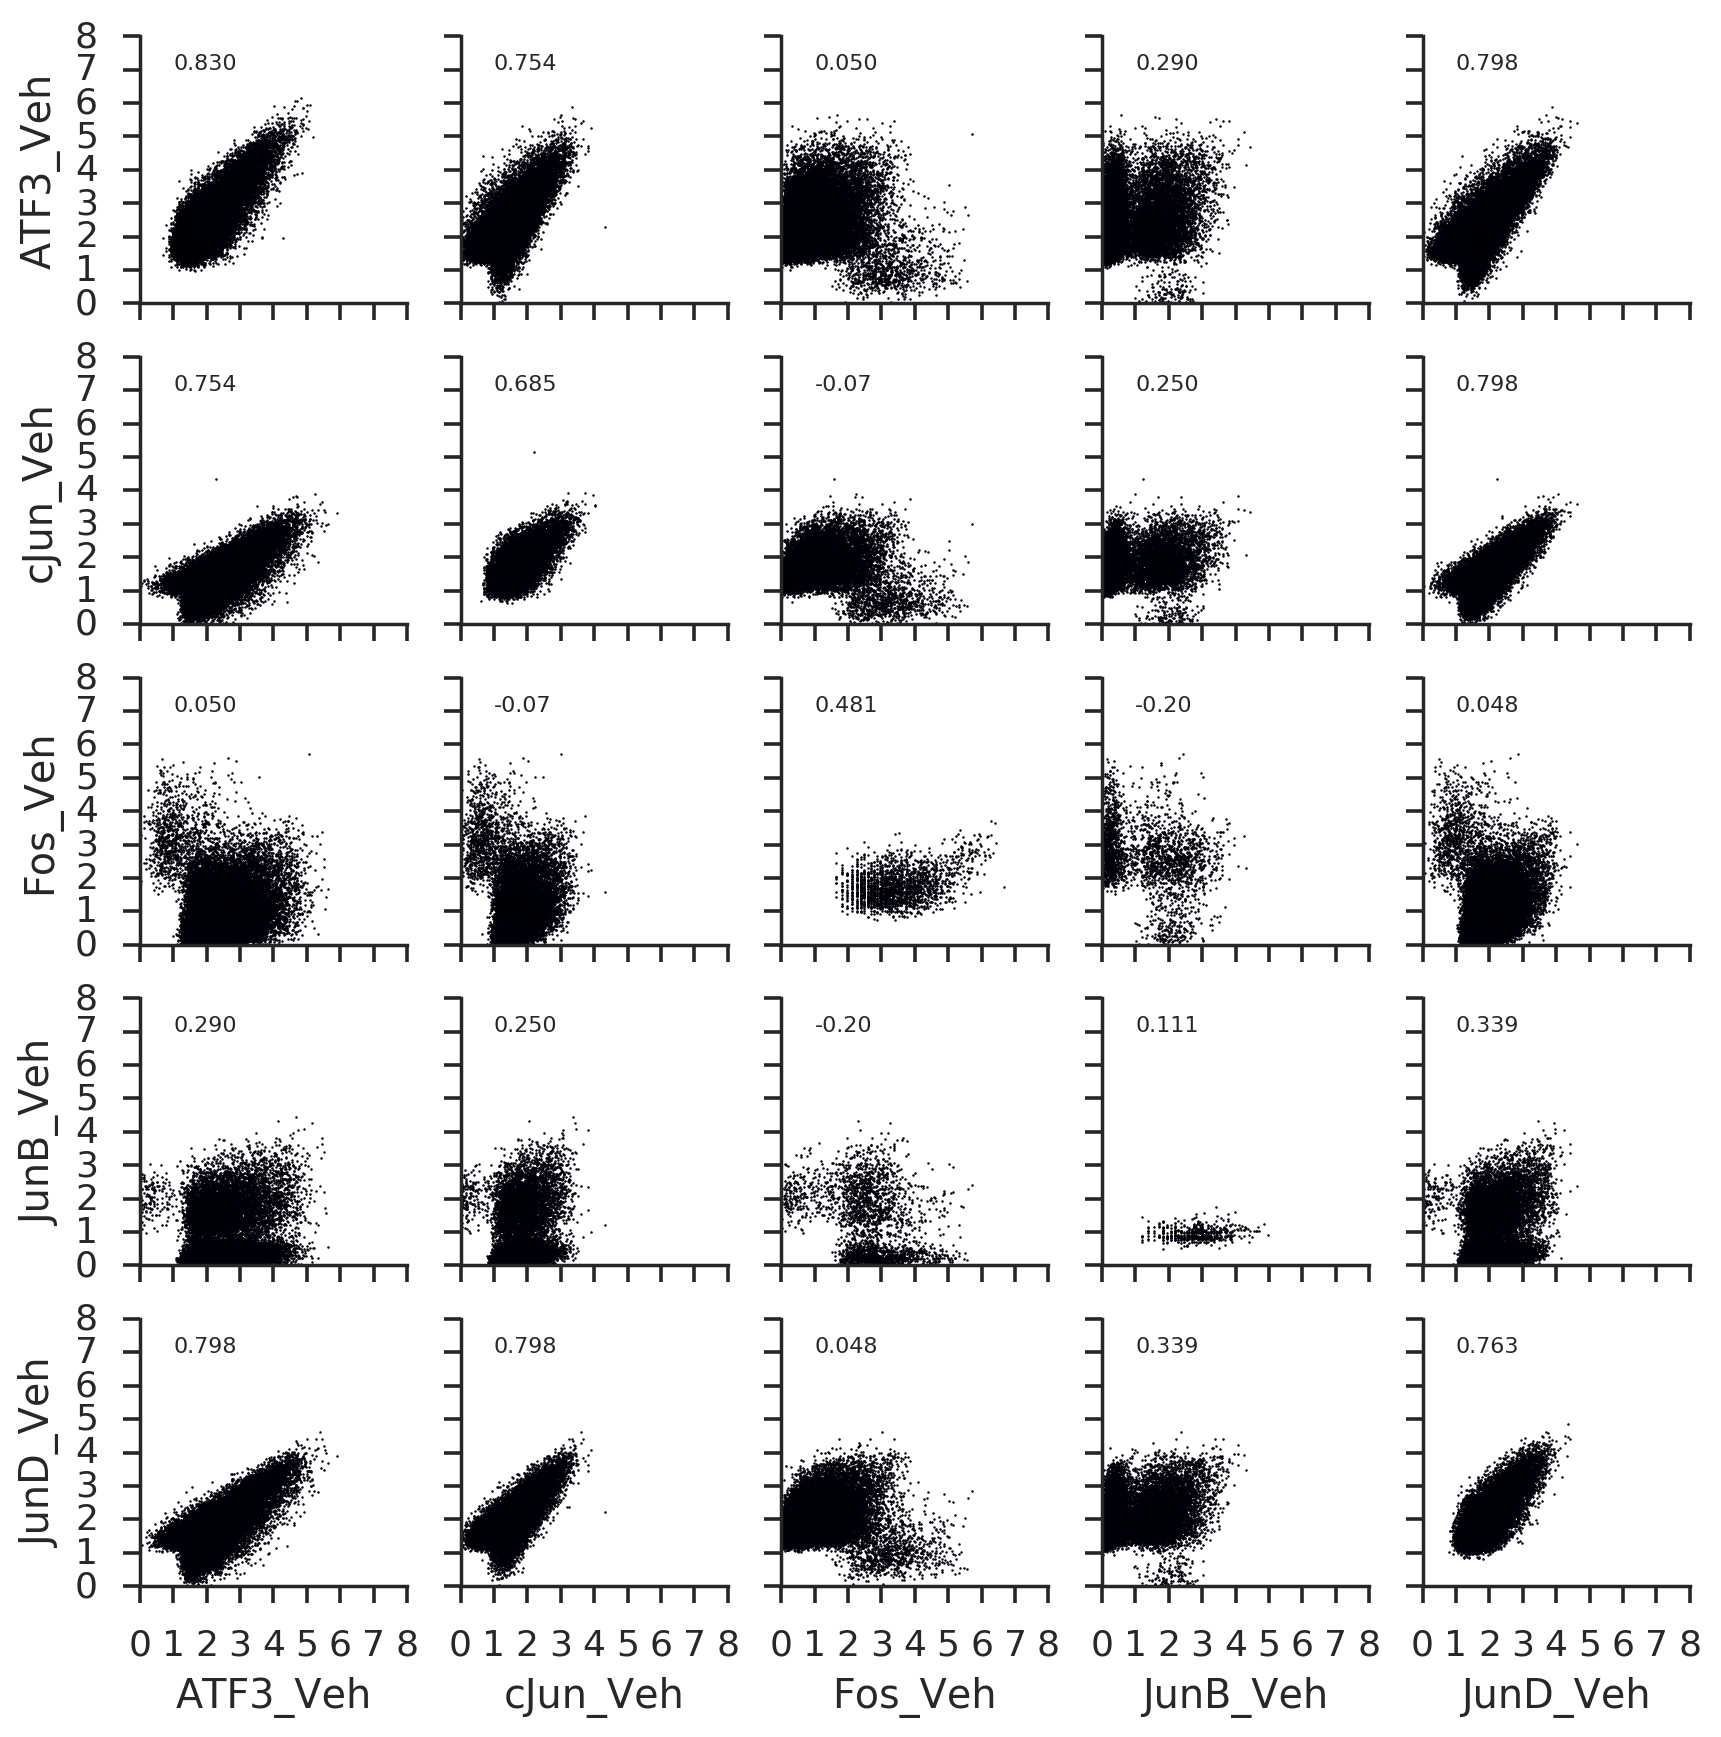

In [537]:
### VEHICLE ###
### read in annotated peak file
xlim = 8
ylim = 8
annotated_veh_frame = pd.read_csv('./c57bl6_veh_annotatedPeaks.tsv', sep='\t')
annotated_veh_frame.index = annotated_veh_frame.ix[:,0].values
# average tag counts from both replicates
ap1_veh_tag_frame = pd.read_csv('c57bl6_veh_annotatedPeaks.tsv', sep='\t')
ap1_veh_tag_frame.index = ap1_veh_tag_frame.ix[:,0].values
ap1_veh_tag_frame = ap1_veh_tag_frame[[x for x in ap1_veh_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_veh_tag_frame.columns.values]
ap1_veh_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]), key = lambda x:x.lower())



with sns.axes_style('ticks'):
    fig, axes_array = plt.subplots(len(factor_treatments), len(factor_treatments), figsize=(10,10));


    for i in range(len(factor_treatments)):
        ft1 = factor_treatments[i]
        axes_array[len(factor_treatments) - 1][i].set_xlabel(ft1)
        axes_array[i][0].set_ylabel(ft1)
        for j in range(i, len(factor_treatments)):
            ax = axes_array[j][i]
            ax2 = axes_array[i][j]
            ft2 = factor_treatments[j]
            
            if ft1 == ft2:
                # identify loci that has binding of monomer
                bound_indices = annotated_veh_frame[annotated_veh_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())].index.values
                # plot replicates against each other
                data = ap1_veh_tag_frame[ap1_veh_tag_frame.index.isin(bound_indices)][[x for x in ap1_veh_tag_frame.columns if ft1 in x]]
                filtered_data = [x for x in list(zip(data.ix[:,0], data.ix[:,1])) if x[0] > 0 or x[1] > 0]
                rep1_vals = np.array([x[0] for x in filtered_data])
                rep2_vals = np.array([x[1] for x in filtered_data])
                logged_rep1_vals = np.log2(rep1_vals + 1)
                logged_rep2_vals = np.log2(rep2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(rep1_vals, rep2_vals)
                ax.scatter(logged_rep1_vals, logged_rep2_vals, marker = '.', s = 1)
                
            else:
                # identify loci that has binding of either monomer
                bound_indices = annotated_veh_frame[
                                                    (annotated_veh_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())) |
                                                    (annotated_veh_frame['Focus Ratio/Region Size'].str.contains(ft2.lower()))
                                                    ].index.values
                ft1_vals = ap1_veh_tag_frame[ap1_veh_tag_frame.index.isin(bound_indices)][[x for x in ap1_veh_tag_frame.columns if ft1 in x]].mean(axis=1).values
                ft2_vals = ap1_veh_tag_frame[ap1_veh_tag_frame.index.isin(bound_indices)][[x for x in ap1_veh_tag_frame.columns if ft2 in x]].mean(axis=1).values
                filtered_data = [x for x in list(zip(ft1_vals, ft2_vals)) if x[0] > 0 or x[1] > 0]
                ft1_vals = np.array([x[0] for x in filtered_data])
                ft2_vals = np.array([x[1] for x in filtered_data])
#                 ft1_vals, ft2_vals = quantileNormalize(ft1_vals, ft2_vals)
                logged_ft1_vals = np.log2(ft1_vals + 1)
                logged_ft2_vals = np.log2(ft2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(ft1_vals, ft2_vals)
                ax.scatter(logged_ft1_vals, logged_ft2_vals, marker = '.', s = 1)
                ax2.scatter(logged_ft2_vals,logged_ft1_vals, marker = '.', s = 1)
#                 axes_array[i][j].set_axis_off()
                
                ax2.set_xlim(0,xlim)
                ax2.set_ylim(0,ylim)
                ax2.set_aspect(1)

                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)


            ax.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)
                
            ax.set_xlim(0,xlim)
            ax.set_ylim(0,ylim)
            ax.set_aspect(1)
            
            
            sns.despine()   
            if j < len(factor_treatments) - 1:
                ax.set_xticklabels([])
            if i > 0:
                ax.set_yticklabels([])
                
            

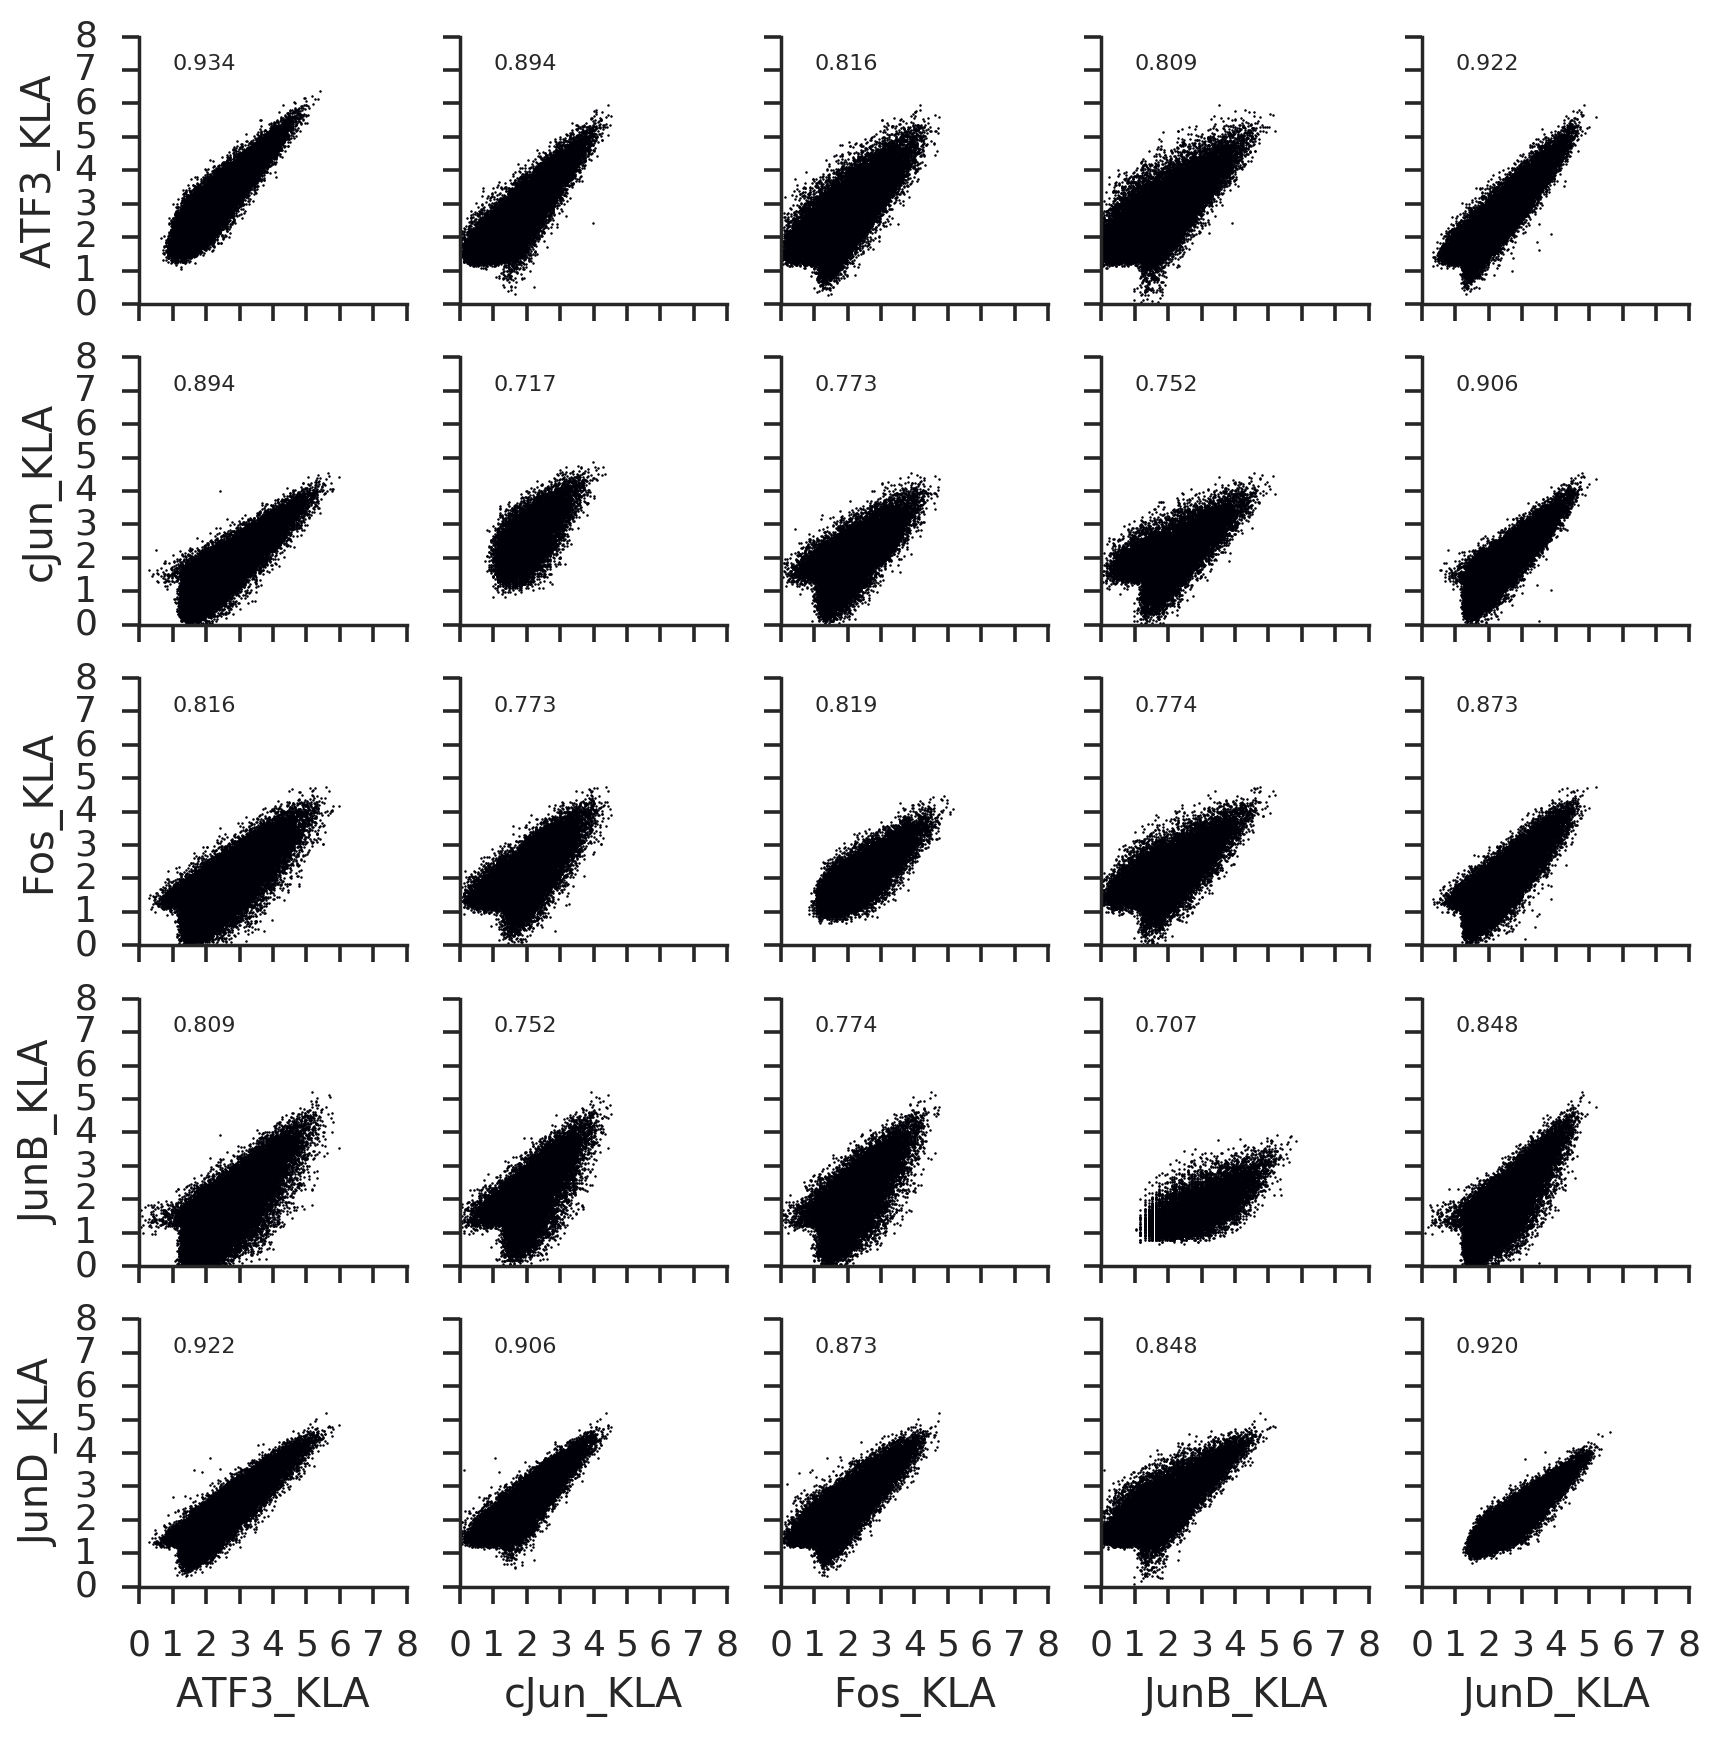

In [538]:
### KLA ###
### read in annotated peak file
xlim = 8
ylim = 8
annotated_kla_frame = pd.read_csv('./c57bl6_kla_annotatedPeaks.tsv', sep='\t')
annotated_kla_frame.index = annotated_kla_frame.ix[:,0].values
# average tag counts from both replicates
ap1_kla_tag_frame = pd.read_csv('c57bl6_kla_annotatedPeaks.tsv', sep='\t')
ap1_kla_tag_frame.index = ap1_kla_tag_frame.ix[:,0].values
ap1_kla_tag_frame = ap1_kla_tag_frame[[x for x in ap1_kla_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_kla_tag_frame.columns.values]
ap1_kla_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]), key = lambda x:x.lower())



with sns.axes_style('ticks'):
    fig, axes_array = plt.subplots(len(factor_treatments), len(factor_treatments), figsize=(10,10));


    for i in range(len(factor_treatments)):
        ft1 = factor_treatments[i]
        axes_array[len(factor_treatments) - 1][i].set_xlabel(ft1)
        axes_array[i][0].set_ylabel(ft1)
        for j in range(i, len(factor_treatments)):
            ax = axes_array[j][i]
            ax2 = axes_array[i][j]
            ft2 = factor_treatments[j]
            
            if ft1 == ft2:
                # identify loci that has binding of monomer
                bound_indices = annotated_kla_frame[annotated_kla_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())].index.values
                # plot replicates against each other
                data = ap1_kla_tag_frame[ap1_kla_tag_frame.index.isin(bound_indices)][[x for x in ap1_kla_tag_frame.columns if ft1 in x]]
                filtered_data = [x for x in list(zip(data.ix[:,0], data.ix[:,1])) if x[0] > 0 or x[1] > 0]
                rep1_vals = np.array([x[0] for x in filtered_data])
                rep2_vals = np.array([x[1] for x in filtered_data])
                logged_rep1_vals = np.log2(rep1_vals + 1)
                logged_rep2_vals = np.log2(rep2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(rep1_vals, rep2_vals)
                ax.scatter(logged_rep1_vals, logged_rep2_vals, marker = '.', s = 1)
                
            else:
                # identify loci that has binding of either monomer
                bound_indices = annotated_kla_frame[
                                                    (annotated_kla_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())) |
                                                    (annotated_kla_frame['Focus Ratio/Region Size'].str.contains(ft2.lower()))
                                                    ].index.values
                ft1_vals = ap1_kla_tag_frame[ap1_kla_tag_frame.index.isin(bound_indices)][[x for x in ap1_kla_tag_frame.columns if ft1 in x]].mean(axis=1).values
                ft2_vals = ap1_kla_tag_frame[ap1_kla_tag_frame.index.isin(bound_indices)][[x for x in ap1_kla_tag_frame.columns if ft2 in x]].mean(axis=1).values
                filtered_data = [x for x in list(zip(ft1_vals, ft2_vals)) if x[0] > 0 or x[1] > 0]
                ft1_vals = np.array([x[0] for x in filtered_data])
                ft2_vals = np.array([x[1] for x in filtered_data])

                logged_ft1_vals = np.log2(ft1_vals + 1)
                logged_ft2_vals = np.log2(ft2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(ft1_vals, ft2_vals)
                ax.scatter(logged_ft1_vals, logged_ft2_vals, marker = '.', s = 1)
                ax2.scatter(logged_ft2_vals,logged_ft1_vals, marker = '.', s = 1)
#                 axes_array[i][j].set_axis_off()
                
                ax2.set_xlim(0,xlim)
                ax2.set_ylim(0,ylim)
                ax2.set_aspect(1)

                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)


            ax.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)
                
            ax.set_xlim(0,xlim)
            ax.set_ylim(0,ylim)
            ax.set_aspect(1)
            
            
            sns.despine()   
            if j < len(factor_treatments) - 1:
                ax.set_xticklabels([])
            if i > 0:
                ax.set_yticklabels([])
                
            

## Strains Peak Calling

### Preprocessing

In [ ]:
# file directories

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(workingDirectory + '/tag_directories_strains')):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in sorted(os.listdir(workingDirectory + '/tag_directories_strains')):
    logFile = [x for x in os.listdir(workingDirectory + '/tag_directories_strains' + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(workingDirectory + '/tag_directories_strains' + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(workingDirectory + '/tag_directories_strains'):
    with open(workingDirectory + '/tag_directories_strains/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

### Filter Samples According to Mapping Quality

In [ ]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

In [ ]:
# don't use NOD samples
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['strain'] == 'Balbc']

In [ ]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
### call peaks ###
# iterate through each individual file
! if [ ! -d ./peak_files_strains/ ]; then mkdir ./peak_files_strains; fi

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr_strains.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer_strains.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    if not 'input' in tagDir.lower():
    # call peaks only for experiments that passed thresholding
        metaDataTokens = tagDir.split("_")
        treatment = metaDataTokens[4]
        strain = metaDataTokens[0]

        peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
        peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

        if strain == 'Balbc':
            if "veh" in treatment.lower():
                inputDir = './input_data/Balbc_Thiomac_ChIP_Input_Veh_GJF_16-06-12'
            elif "kla" in treatment.lower():
                inputDir = './input_data/Balbc_Thiomac_ChIP_Input_KLA-1h_GJF_16-06-12'        
        elif strain == 'NOD':
            if "veh" in treatment.lower():
                inputDir = './input_data/NOD_Thiomac_ChIP_Input_Veh_GFEW_15-10-19'
            elif "kla" in treatment.lower():
                inputDir = './input_data/NOD_Thiomac_ChIP_Input_KLA-1h_GFEW_15-10-19'
        scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                         ' -i ' + inputDir
                         + ' -L 0 -C 0 -fdr 0.9' 
#                          + ' -minTagThreshold 4'
                         + ' -style factor -size 200 -minDist 200 > ' + 
                         './peak_files_strains/' + peakFileName1 + ' &\n')
        scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -style factor -size 200  > ' + 
                     './peak_files_strains/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()




In [ ]:
%%bash
rm ./peak_files_strains/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr_strains.sh

### Run IDR for strains

In [ ]:
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_strains/'
scriptFile = open(scratchDirectory + '/run_idr_strains.sh', 'w')

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./idr_strains/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
counter = 0
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = './peak_files_strains/' + sample1 + '_peaks.tsv'
            peakFile2 = './peak_files_strains/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.05"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

In [ ]:
%%bash
rm ./idr_strains/*
chmod a+x ./scratch/*
bash ./scratch/run_idr_strains.sh

In [ ]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_strains//'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar', col='strain')
# plt.ylim([0,30000])
    

In [ ]:
outFile = open('./best_samples_strains.tsv','w')
! if [ ! -d idrPeaks_strains ]; then mkdir idrPeaks_strains; fi
!rm ./idrPeaks_strains/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks_strains/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()

In [ ]:
# create a symbolic link for each of the best tag directories
actualDir = '/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
linkDir = '/home/jtao/analysis/cobinding_motif_analysis/tag_directories_strains/'
if not os.path.isdir(linkDir):
    os.mkdir(linkDir)
else:
    for f in os.listdir(linkDir):
        os.remove(linkDir + '/' + f)
### create links for peak data ###   
for key in [
 'balbc_atf3_kla',
 'balbc_atf3_veh',
 'balbc_cebpa_kla',
 'balbc_cebpa_veh',
 'balbc_cjun_kla',
 'balbc_cjun_veh',
 'balbc_fos_kla',
 'balbc_fos_veh',
 'balbc_fra2_veh',
 'balbc_fra2_kla',
 'balbc_junb_kla',
 'balbc_junb_veh',
 'balbc_jund_kla',
 'balbc_jund_veh',
 'balbc_p65_kla',
 'balbc_p65_veh',
 'balbc_pu1_kla',
 'balbc_pu1_veh']:
    if key in factorTreatment_bestIDR_dict:
        p = factorTreatment_bestIDR_dict[key]
        tokens = p.split('_')
        strain = tokens[0]
        factor = tokens[1]
        treatment = tokens[2]
        sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
        sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
        os.system('ln -s ' + actualDir + '/' + sample1 + ' ' + linkDir + '/'+sample1)
        os.system('ln -s ' + actualDir + '/' + sample2 + ' ' + linkDir + '/'+sample2)

### create links for input data ###
os.system('ln -s '+ actualDir.replace('tag_directories_strains', 'input_data') + '/Balbc_Thiomac_ChIP_Input_Veh_GJF_16-06-12 ' + linkDir + '/Balbc_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20')
os.system('ln -s '+ actualDir.replace('tag_directories_strains', 'input_data') + '/Balbc_Thiomac_ChIP_Input_KLA-1h_GJF_16-06-12 ' + linkDir + '/Balbc_Thiomac_ChIP_Input_Veh_GJF_15-03-20')

In [21]:
# create track hub containing best samples
tagDirectories = []
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_strains/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ap1_idr_strains mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString
! makeMultiWigHub.pl ap1_idr_strains mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString

makeMultiWigHub.pl ap1_idr_strains mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 1e6 -d ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-07-25 ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16-rep1 ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16 ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16-rep1 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_KLA-1h_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_KLA-1h_GJF_16-06-12 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_Veh_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_Veh_GJF_16-06-12 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_KLA-1h_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_KLA-1h_GJF_16-07-22 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_Veh_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_Veh_GJF_16-07-22 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fra2_KLA-1h_GJF_17-04-17

### Create Scatter Plot Visualization

In [548]:
strain = 'balbc'
factors = ['atf3', 'cjun', 'fos', 'junb', 'jund']

In [549]:
%%capture
# merge peaks
peak_file_string = ''
for treatment in ['veh', 'kla']:
    for factor in factors:
        peak_file_string = peak_file_string + ' ./idrPeaks_strains/' + strain + '_' + factor + '_' + treatment + '_peaks.tsv'
    mergedName = './balbc_' + treatment + '_mergedPeaks.tsv'
    ! mergePeaks $peak_file_string > $mergedName

    # annotate peaks
    tagDirectory_string = ''
    for factor in factors:
        
        p = factorTreatment_bestIDR_dict[strain + '_' + factor + '_' + treatment]
        tokens = p.split('_')
        strain = tokens[0]
        factor = tokens[1]
        treatment = tokens[2]
        sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
        sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
        
        tagDirectory_string = tagDirectory_string + ' ./tag_directories_strains/' + sample1 + ' ./tag_directories_strains/' + sample2
        tagDirectory_string = tagDirectory_string.strip()
        annotatedName = './balbc_' + treatment + '_annotatedPeaks.tsv'
        ! annotatePeaks.pl $mergedName mm10 -norm 1e6 -size given -d $tagDirectory_string > $annotatedName

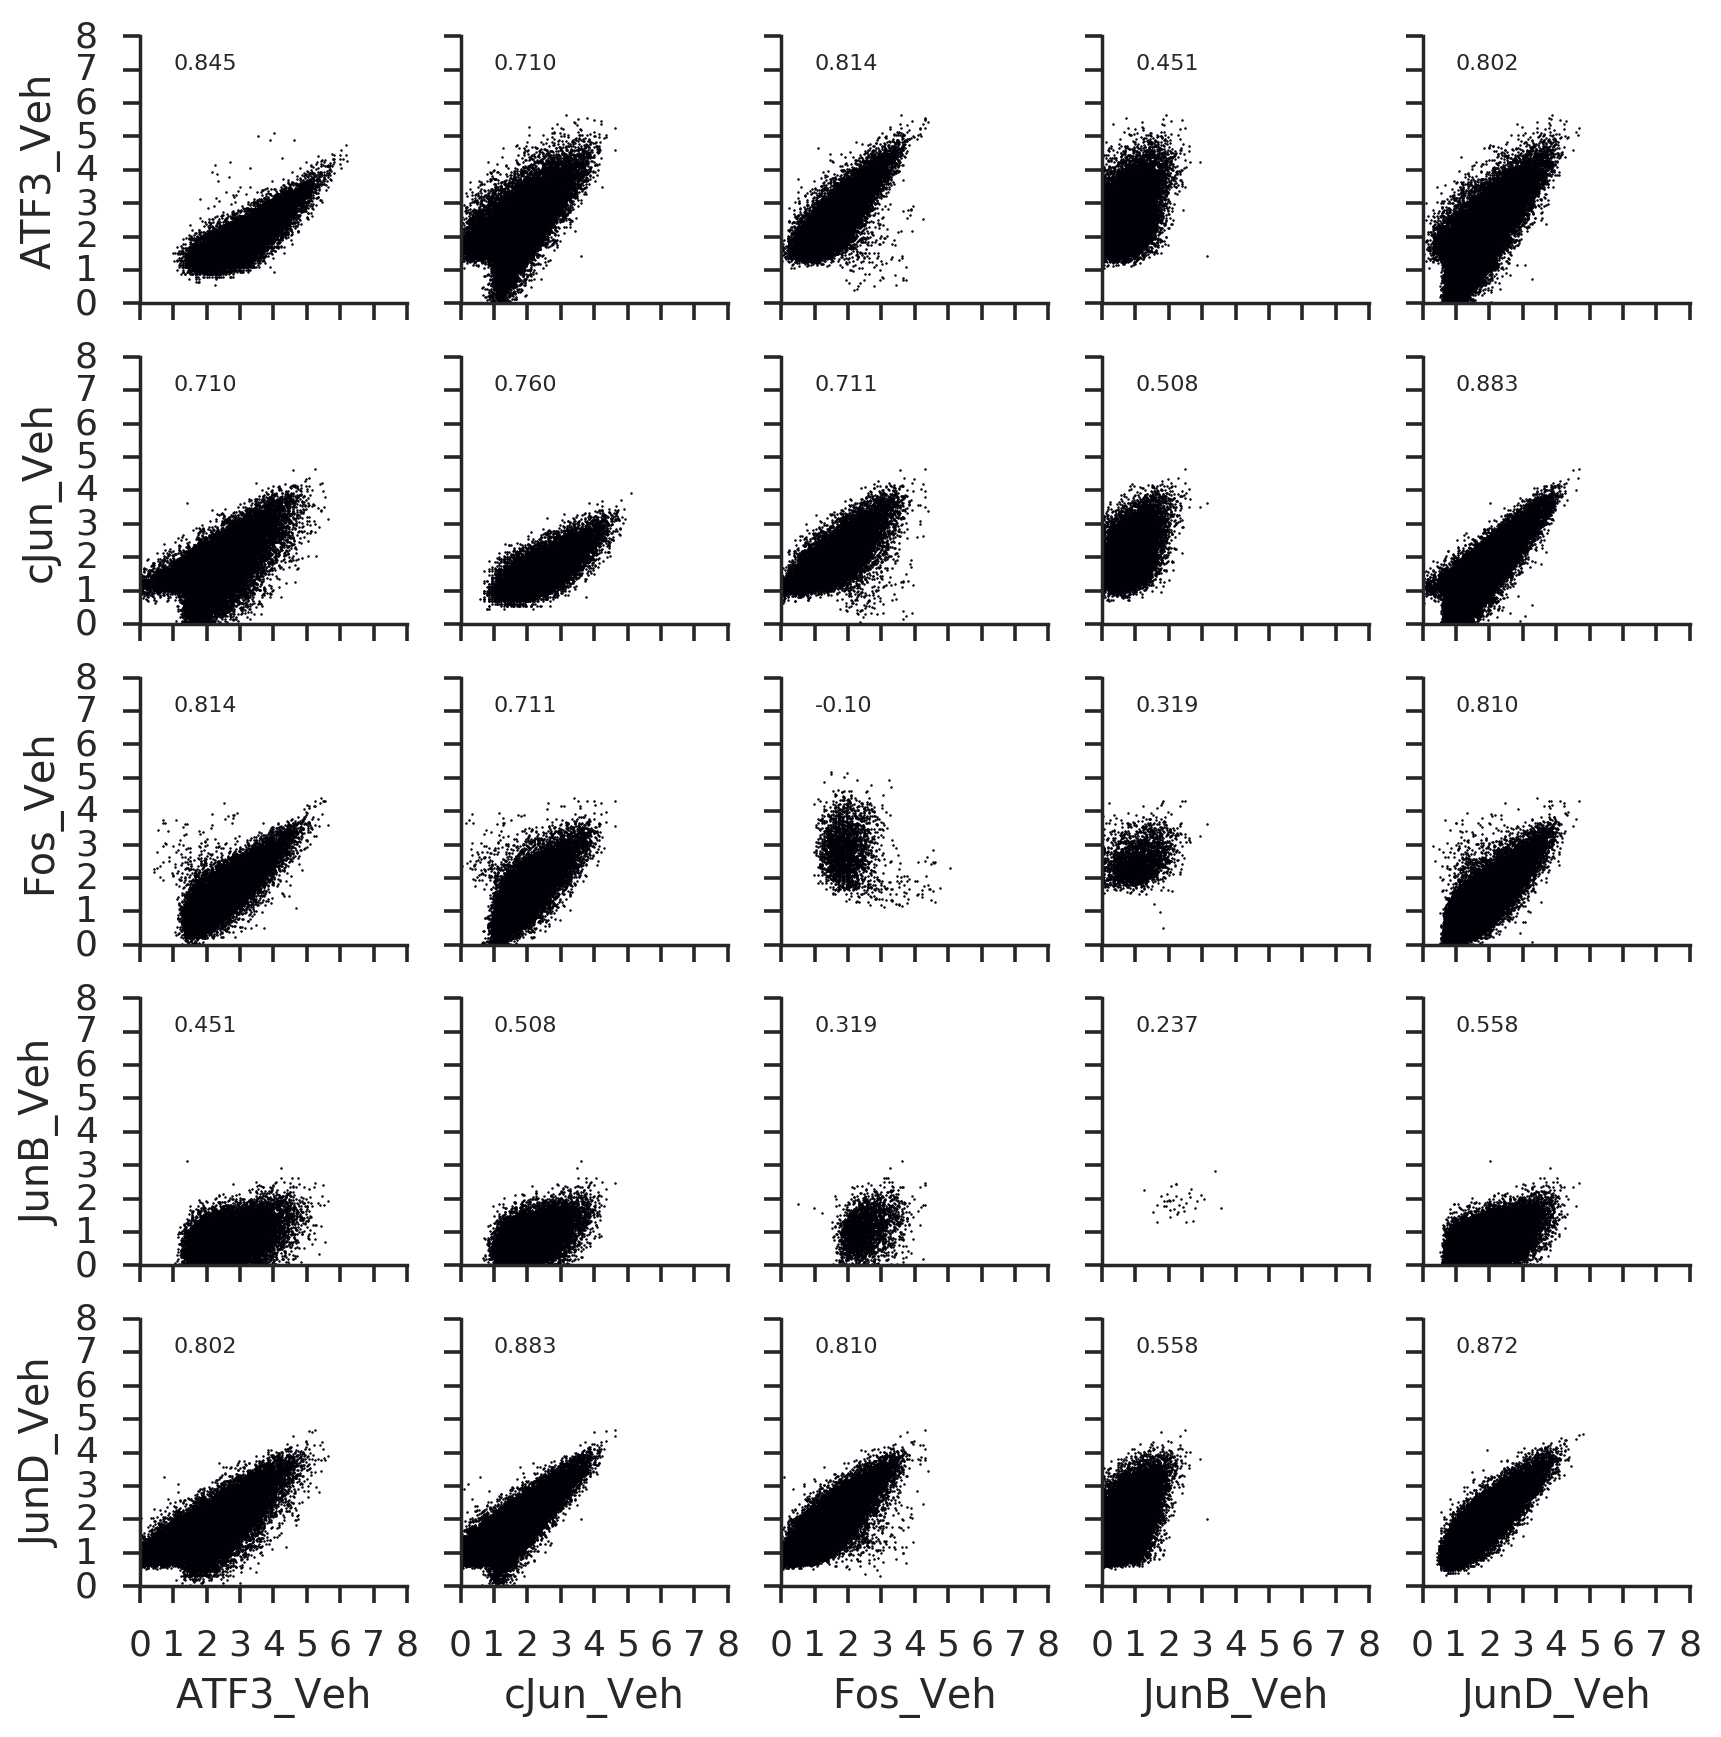

In [550]:
### VEHICLE ###
### read in annotated peak file
xlim = 8
ylim = 8
annotated_veh_frame = pd.read_csv('./balbc_veh_annotatedPeaks.tsv', sep='\t')
annotated_veh_frame.index = annotated_veh_frame.ix[:,0].values
# average tag counts from both replicates
ap1_veh_tag_frame = pd.read_csv('balbc_veh_annotatedPeaks.tsv', sep='\t')
ap1_veh_tag_frame.index = ap1_veh_tag_frame.ix[:,0].values
ap1_veh_tag_frame = ap1_veh_tag_frame[[x for x in ap1_veh_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_veh_tag_frame.columns.values]
ap1_veh_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]), key = lambda x:x.lower())



with sns.axes_style('ticks'):
    fig, axes_array = plt.subplots(len(factor_treatments), len(factor_treatments), figsize=(10,10));


    for i in range(len(factor_treatments)):
        ft1 = factor_treatments[i]
        axes_array[len(factor_treatments) - 1][i].set_xlabel(ft1)
        axes_array[i][0].set_ylabel(ft1)
        for j in range(i, len(factor_treatments)):
            ax = axes_array[j][i]
            ax2 = axes_array[i][j]
            ft2 = factor_treatments[j]
            
            if ft1 == ft2:
                # identify loci that has binding of monomer
                bound_indices = annotated_veh_frame[annotated_veh_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())].index.values
                # plot replicates against each other
                data = ap1_veh_tag_frame[ap1_veh_tag_frame.index.isin(bound_indices)][[x for x in ap1_veh_tag_frame.columns if ft1 in x]]
                filtered_data = [x for x in list(zip(data.ix[:,0], data.ix[:,1])) if x[0] > 0 or x[1] > 0]
                rep1_vals = np.array([x[0] for x in filtered_data])
                rep2_vals = np.array([x[1] for x in filtered_data])
                logged_rep1_vals = np.log2(rep1_vals + 1)
                logged_rep2_vals = np.log2(rep2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(rep1_vals, rep2_vals)
                ax.scatter(logged_rep1_vals, logged_rep2_vals, marker = '.', s = 1)
                
            else:
                # identify loci that has binding of either monomer
                bound_indices = annotated_veh_frame[
                                                    (annotated_veh_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())) |
                                                    (annotated_veh_frame['Focus Ratio/Region Size'].str.contains(ft2.lower()))
                                                    ].index.values
                ft1_vals = ap1_veh_tag_frame[ap1_veh_tag_frame.index.isin(bound_indices)][[x for x in ap1_veh_tag_frame.columns if ft1 in x]].mean(axis=1).values
                ft2_vals = ap1_veh_tag_frame[ap1_veh_tag_frame.index.isin(bound_indices)][[x for x in ap1_veh_tag_frame.columns if ft2 in x]].mean(axis=1).values
                filtered_data = [x for x in list(zip(ft1_vals, ft2_vals)) if x[0] > 0 or x[1] > 0]
                ft1_vals = np.array([x[0] for x in filtered_data])
                ft2_vals = np.array([x[1] for x in filtered_data])
#                 ft1_vals, ft2_vals = quantileNormalize(ft1_vals, ft2_vals)
                logged_ft1_vals = np.log2(ft1_vals + 1)
                logged_ft2_vals = np.log2(ft2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(ft1_vals, ft2_vals)
                ax.scatter(logged_ft1_vals, logged_ft2_vals, marker = '.', s = 1)
                ax2.scatter(logged_ft2_vals,logged_ft1_vals, marker = '.', s = 1)
#                 axes_array[i][j].set_axis_off()
                
                ax2.set_xlim(0,xlim)
                ax2.set_ylim(0,ylim)
                ax2.set_aspect(1)

                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)


            ax.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)
                
            ax.set_xlim(0,xlim)
            ax.set_ylim(0,ylim)
            ax.set_aspect(1)
            
            
            sns.despine()   
            if j < len(factor_treatments) - 1:
                ax.set_xticklabels([])
            if i > 0:
                ax.set_yticklabels([])
                
            

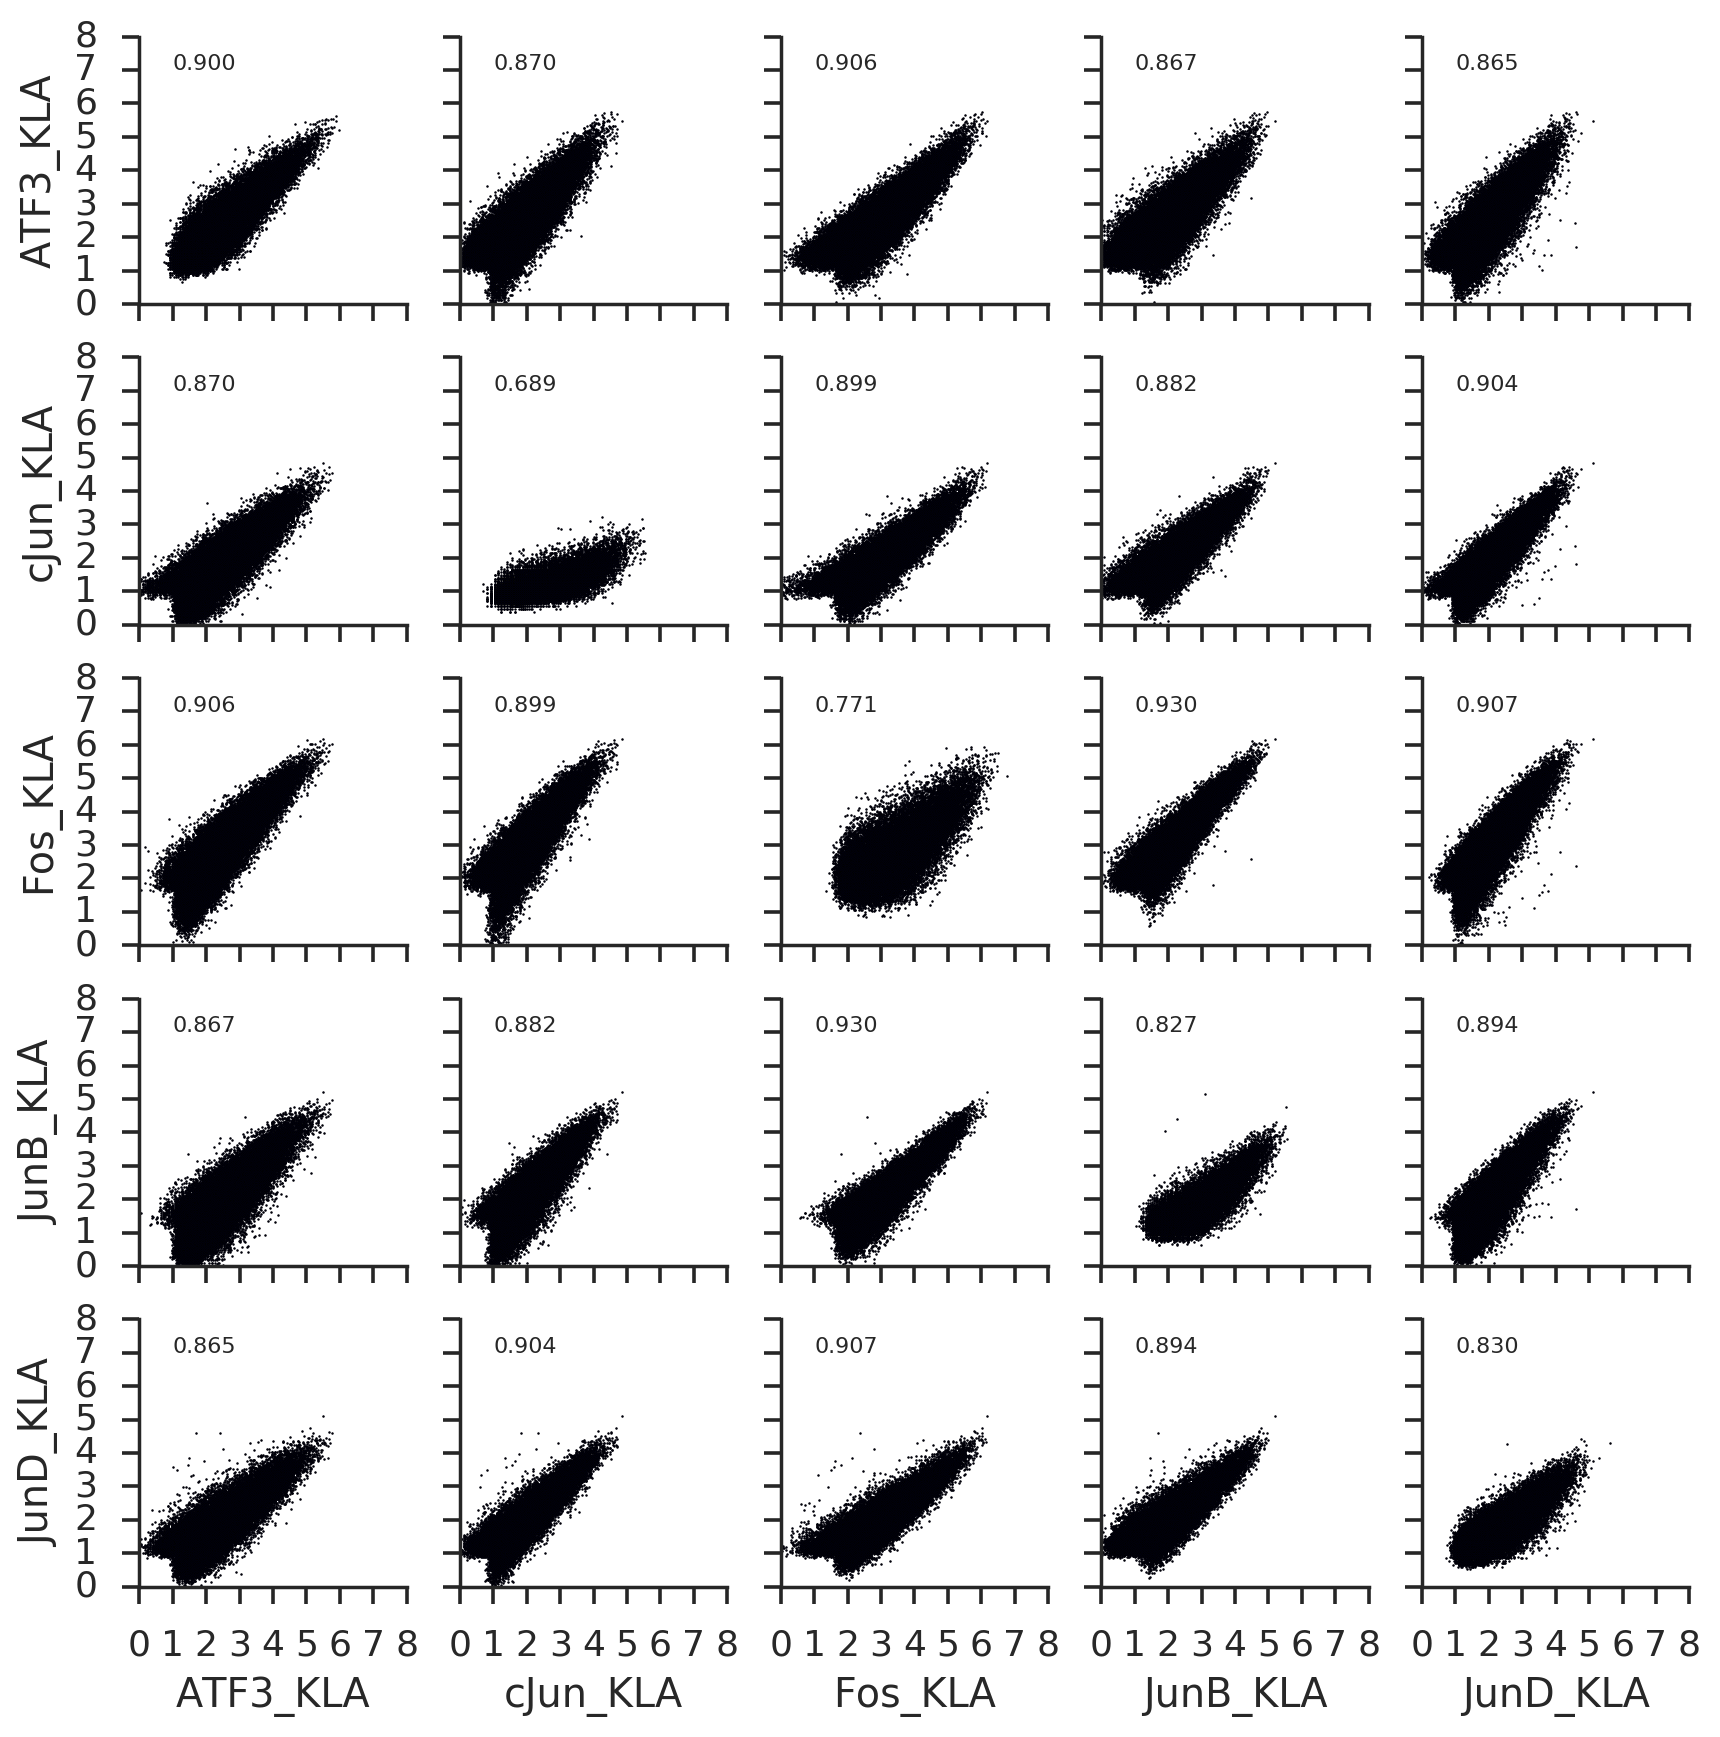

In [551]:
### KLA ###
### read in annotated peak file
xlim = 8
ylim = 8
annotated_kla_frame = pd.read_csv('./balbc_kla_annotatedPeaks.tsv', sep='\t')
annotated_kla_frame.index = annotated_kla_frame.ix[:,0].values
# average tag counts from both replicates
ap1_kla_tag_frame = pd.read_csv('balbc_kla_annotatedPeaks.tsv', sep='\t')
ap1_kla_tag_frame.index = ap1_kla_tag_frame.ix[:,0].values
ap1_kla_tag_frame = ap1_kla_tag_frame[[x for x in ap1_kla_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_kla_tag_frame.columns.values]
ap1_kla_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]), key = lambda x:x.lower())



with sns.axes_style('ticks'):
    fig, axes_array = plt.subplots(len(factor_treatments), len(factor_treatments), figsize=(10,10));


    for i in range(len(factor_treatments)):
        ft1 = factor_treatments[i]
        axes_array[len(factor_treatments) - 1][i].set_xlabel(ft1)
        axes_array[i][0].set_ylabel(ft1)
        for j in range(i, len(factor_treatments)):
            ax = axes_array[j][i]
            ax2 = axes_array[i][j]
            ft2 = factor_treatments[j]
            
            if ft1 == ft2:
                # identify loci that has binding of monomer
                bound_indices = annotated_kla_frame[annotated_kla_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())].index.values
                # plot replicates against each other
                data = ap1_kla_tag_frame[ap1_kla_tag_frame.index.isin(bound_indices)][[x for x in ap1_kla_tag_frame.columns if ft1 in x]]
                filtered_data = [x for x in list(zip(data.ix[:,0], data.ix[:,1])) if x[0] > 0 or x[1] > 0]
                rep1_vals = np.array([x[0] for x in filtered_data])
                rep2_vals = np.array([x[1] for x in filtered_data])
                logged_rep1_vals = np.log2(rep1_vals + 1)
                logged_rep2_vals = np.log2(rep2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(rep1_vals, rep2_vals)
                ax.scatter(logged_rep1_vals, logged_rep2_vals, marker = '.', s = 1)
                
            else:
                # identify loci that has binding of either monomer
                bound_indices = annotated_kla_frame[
                                                    (annotated_kla_frame['Focus Ratio/Region Size'].str.contains(ft1.lower())) |
                                                    (annotated_kla_frame['Focus Ratio/Region Size'].str.contains(ft2.lower()))
                                                    ].index.values
                ft1_vals = ap1_kla_tag_frame[ap1_kla_tag_frame.index.isin(bound_indices)][[x for x in ap1_kla_tag_frame.columns if ft1 in x]].mean(axis=1).values
                ft2_vals = ap1_kla_tag_frame[ap1_kla_tag_frame.index.isin(bound_indices)][[x for x in ap1_kla_tag_frame.columns if ft2 in x]].mean(axis=1).values
                filtered_data = [x for x in list(zip(ft1_vals, ft2_vals)) if x[0] > 0 or x[1] > 0]
                ft1_vals = np.array([x[0] for x in filtered_data])
                ft2_vals = np.array([x[1] for x in filtered_data])
#                 ft1_vals, ft2_vals = quantileNormalize(ft1_vals, ft2_vals)
                logged_ft1_vals = np.log2(ft1_vals + 1)
                logged_ft2_vals = np.log2(ft2_vals + 1)
                pearson, pval = scipy.stats.pearsonr(ft1_vals, ft2_vals)
                ax.scatter(logged_ft1_vals, logged_ft2_vals, marker = '.', s = 1)
                ax2.scatter(logged_ft2_vals,logged_ft1_vals, marker = '.', s = 1)
#                 axes_array[i][j].set_axis_off()
                
                ax2.set_xlim(0,xlim)
                ax2.set_ylim(0,ylim)
                ax2.set_aspect(1)

                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)


            ax.annotate(xy=(1,ylim - 1), s=str(pearson)[:5], size=8)
                
            ax.set_xlim(0,xlim)
            ax.set_ylim(0,ylim)
            ax.set_aspect(1)
            
            
            sns.despine()   
            if j < len(factor_treatments) - 1:
                ax.set_xticklabels([])
            if i > 0:
                ax.set_yticklabels([])
                
            

## Validation Peak Calling

### Preprocessing

In [58]:
# file directories

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(workingDirectory + '/tag_directories_validation')):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in sorted(os.listdir(workingDirectory + '/tag_directories_validation')):
    logFile = [x for x in os.listdir(workingDirectory + '/tag_directories_validation' + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(workingDirectory + '/tag_directories_validation' + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(workingDirectory + '/tag_directories_validation'):
    with open(workingDirectory + '/tag_directories_validation/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:116: FutureWarning: sort(....) is deprecated, use sort_index(.....)


### Filter Samples According to Mapping Quality

In [59]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 100000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

Number of Samples: 57
Number of discarded samples: 5
Number of Samples remaining after filtering: 52


In [60]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories_validation/'
### call peaks ###
# iterate through each individual file
! if [ ! -d ./peak_files_validation/ ]; then mkdir ./peak_files_validation; else rm ./peak_files_validation/*; fi

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr_validation.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer_validation.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    if not 'input' in tagDir.lower():
    # call peaks only for experiments that passed thresholding
        metaDataTokens = tagDir.split("_")
        treatment = metaDataTokens[4]

        peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
        peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

        if "veh" in treatment.lower():
            inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
        elif "kla" in treatment.lower():
            inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
        if 'ppar' in peakFileName1:
            if "veh" in treatment.lower():
                inputDir = './input_data/C57Bl6-PPARgKO_Thiomac_ChIP_Input_Veh_GJF_16-07-23-1/'
        if 'ppar' in peakFileName1:
            if 'veh' in treatment.lower():
                inputDir = './input_data/C57Bl6-LXRKO_Thiomac_ChIP_Input_Veh_GJF_17-04-17-rep1/'
        scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                         ' -i ' + inputDir
                         + ' -L 0 -C 0 -fdr 0.9'
                         + ' -style factor -size 200  > ' + 
                         './peak_files_validation/' + peakFileName1 + ' &\n')
        scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -style factor -size 200 -minDist 200 > ' + 
                     './peak_files_validation/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()




rm: cannot remove ‘./peak_files_validation/*’: No such file or directory


In [61]:
%%bash
rm ./peak_files_validation/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr_validation.sh

rm: cannot remove ‘./peak_files_validation/*’: No such file or directory
	Fragment Length = 113
	Fragment Length = 88
	Fragment Length = 146
	Fragment Length = 147
	Fragment Length = 180
	Total Tags = 160586.0
	Total Tags = 21458548.0
	Total Tags = 17331457.0
	Tags per bp = 0.000080
	Tags per bp = 0.010729
	Tags per bp = 0.008666
	Fragment Length = 145
	Total Tags = 5318743.0
	Tags per bp = 0.002659
	Total Tags = 301795.0
	Tags per bp = 0.000151
	Fragment Length = 110
	Total Tags = 16995197.0
	Tags per bp = 0.008498
	Max tags per bp set automatically to 1.0
	Max tags per bp set automatically to 1.0
	Max tags per bp set automatically to 1.0
	Fragment Length = 151
	Total Tags = 18364456.0
	Tags per bp = 0.009182
	Max tags per bp set automatically to 1.0
	Fragment Length = 138
	Total Tags = 5703484.0
	Tags per bp = 0.002852
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Max tags per bp set automatically to 1.0
	Fragment Length = 130
	Total Tags =

In [65]:
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_validation/'
scriptFile = open(scratchDirectory + '/run_idr_validation.sh', 'w')

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./idr_validation/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
counter = 0
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = './peak_files_validation/' + sample1 + '_peaks.tsv'
            peakFile2 = './peak_files_validation/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.05"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 56 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

In [66]:
%%bash
rm ./idr_validation/*
chmod a+x ./scratch/*
bash ./scratch/run_idr_validation.sh

/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin/idr --samples /home/jtao/analysis/ap1_analysis/idr_validation//c57bl6_pparg_veh_11-05-25_1_peaks.narrowPeak /home/jtao/analysis/ap1_analysis/idr_validation//c57bl6_pparg_veh_14-12-01_1_peaks.narrowPeak --output-file /home/jtao/analysis/ap1_analysis/idr_validation//c57bl6_pparg_veh_11-05-25_1_peaks_c57bl6_pparg_veh_14-12-01_1_peaks_idr.out --plot --idr-threshold 0.05
Performing IDR analysis on the following samples: ./peak_files_validation/c57bl6_pparg_veh_11-05-25_1_peaks.tsv, ./peak_files_validation/c57bl6_pparg_veh_14-12-01_1_peaks.tsv
Output files will be written to: /home/jtao/analysis/ap1_analysis/idr_validation/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Total Tags'
 'Control Tags (normalized to IP Experiment)' 'Fold Change vs Control'
 'p-value vs Control' 'Score']
idr --samples /home/jtao/analysis/

rm: cannot remove ‘./idr_validation/*’: No such file or directory
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.62 0.65 0.85 0.38]
Traceback (most recent call last):
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin/idr", line 4, in <module>
    __import__('pkg_resources').run_script('idr==2.0.2', 'idr')
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/setuptools-23.0.0-py3.5.egg/pkg_resources/__init__.py", line 719, in run_script
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/setuptools-23.0.0-py3.5.egg/pkg_resources/__init__.py", line 1504, in run_script
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.2-py3.5-linux-x86_64.egg/EGG-INFO/scripts/idr", line 10, in <module>
    idr.idr.main()
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(....) is deprecated, use sort_index(.....)


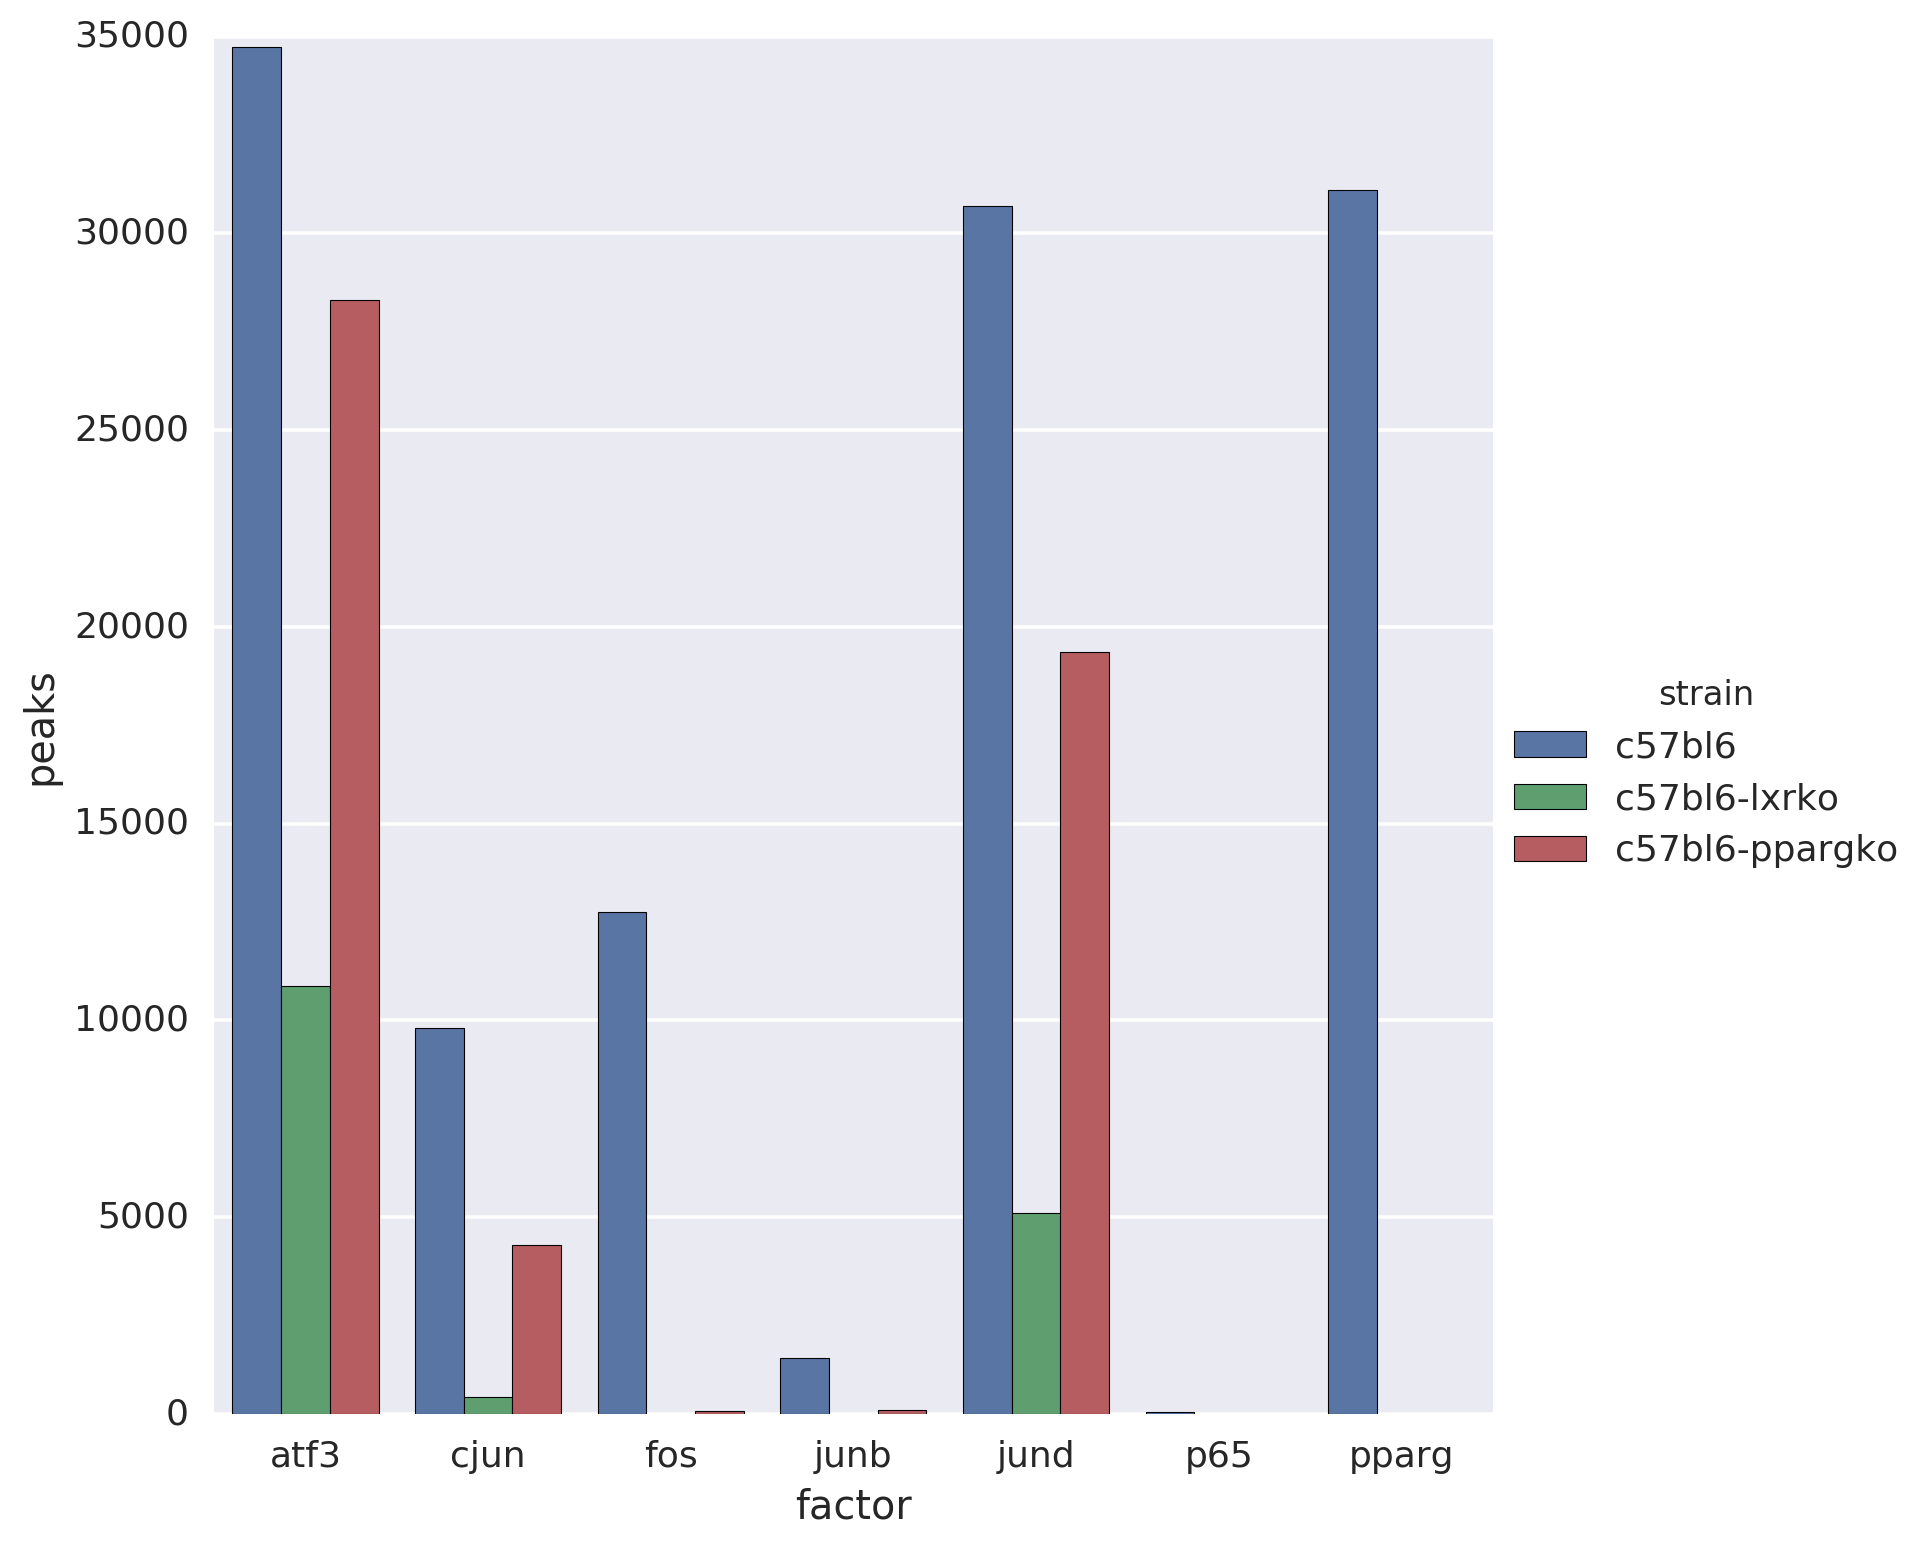

In [67]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_validation/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='strain', size =8, kind='bar')
# plt.ylim([0,30000])
    

In [ ]:
outFile = open('./best_samples_validation.tsv','w')
! if [ ! -d idrPeaks_validation ]; then mkdir idrPeaks_validation; fi
!rm ./idrPeaks_strains/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks_validation/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()

rm: cannot remove ‘./idrPeaks_strains/*’: No such file or directory
c57bl6-lxrko	atf3	veh	C57Bl6-LXRKO_Thiomac_ChIP_Atf3_Veh_GJF_17-04-17-rep1	C57Bl6-LXRKO_Thiomac_ChIP_Atf3_Veh_GJF_17-04-17-rep2	10865
c57bl6-lxrko	cjun	veh	C57Bl6-LXRKO_Thiomac_ChIP_cJun_Veh_GJF_17-04-17-rep1	C57Bl6-LXRKO_Thiomac_ChIP_cJun_Veh_GJF_17-04-17-rep2	419
c57bl6-lxrko	jund	veh	C57Bl6-LXRKO_Thiomac_ChIP_JunD_Veh_GJF_17-04-17-rep1	C57Bl6-LXRKO_Thiomac_ChIP_JunD_Veh_GJF_17-04-17-rep2	5115
c57bl6-ppargko	atf3	veh	C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-2	28318
c57bl6-ppargko	cjun	veh	C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-2	4290
c57bl6-ppargko	fos	veh	C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-2	62
c57bl6-ppargko	junb	veh	C57Bl6-PPARgKO_Thiomac_ChIP_JunB_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_JunB_Veh_GJF_16-07-23-2	104
c57bl6

In [ ]:
# create a symbolic link for each of the best tag directories
actualDir = '/home/jtao/analysis/ap1_analysis/tag_directories/'
linkDir = '/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/'
if not os.path.isdir(linkDir):
    os.mkdir(linkDir)
else:
    for f in os.listdir(linkDir):
        os.remove(linkDir + '/' + f)
### create links for peak data ###   
for key in factorTreatment_bestIDR_dict.keys():
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    os.system('ln -s ' + actualDir + '/' + sample1 + ' ' + linkDir + '/'+sample1)
    os.system('ln -s ' + actualDir + '/' + sample2 + ' ' + linkDir + '/'+sample2)

### create links for input data ###
os.system('ln -s '+ actualDir.replace('tag_directories', 'input_data') + '/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20 ' + linkDir + '/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20')
os.system('ln -s '+ actualDir.replace('tag_directories', 'input_data') + '/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20 ' + linkDir + '/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20')

In [50]:
# create track hub containing best samples
tagDirectories = []
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_validation/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ap1_idr_validation mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString
# ! makeMultiWigHub.pl ap1_idr_validation mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString




makeMultiWigHub.pl ap1_idr_validation mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d ./tag_directories_validation/C57Bl6-LXRKO_Thiomac_ChIP_Atf3_Veh_GJF_17-04-17-rep1 ./tag_directories_validation/C57Bl6-LXRKO_Thiomac_ChIP_Atf3_Veh_GJF_17-04-17-rep2 ./tag_directories_validation/C57Bl6-LXRKO_Thiomac_ChIP_cJun_Veh_GJF_17-04-17-rep1 ./tag_directories_validation/C57Bl6-LXRKO_Thiomac_ChIP_cJun_Veh_GJF_17-04-17-rep2 ./tag_directories_validation/C57Bl6-LXRKO_Thiomac_ChIP_JunD_Veh_GJF_17-04-17-rep1 ./tag_directories_validation/C57Bl6-LXRKO_Thiomac_ChIP_JunD_Veh_GJF_17-04-17-rep2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-1 ./